In [1]:
import gym
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical, Normal

from copy import deepcopy
import matplotlib.pyplot as plt
import random
import time

In [7]:
def simulate(env, horizon, policy, render = False):
    tot_reward = 0
    frame = env.reset()
    frame_buffer = 4 * [preprocess(frame)]
    movie_frame = []
    for t in range(horizon):
        if render:
            #env.render()
            env.render()
            movie_frame.append(env.render(mode="rgb_array"))
            time.sleep(1/24)
            
        state = torch.stack(frame_buffer[-4:]) 
        action = policy(state)
        frame, reward, done, info = env.step(action)
        frame_buffer.append(preprocess(frame))
        next_state = torch.stack(frame_buffer[-4:])
        
        tot_reward += reward
        if done:
            break
            
    if render:    
        env.close()
            
    return tot_reward, reward, done, t, movie_frame


def preprocess(img):
    img_gray = np.mean(img, axis=2)
    img_down = img_gray[::2, ::2]

    return torch.tensor(img_down, dtype = torch.int8)

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0


    def push(self, state, action, next_state, reward, done):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, 
                                      reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self, out_size, hidden_size = 256): 
        super(DQN, self).__init__()

        # an affine operation: y = Wx + b
        self.conv1 = nn.Conv2d(
            in_channels=NUM_FRAMES,
            out_channels=16,
            kernel_size=8,
            stride=4,
            padding=2)
        
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=4,
            stride=2,
            padding=1)
        
        self.fc1 = nn.Linear(4160, hidden_size)  # 6*6 from image dimension
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # In: (4, 105, 80)  Out: (16, 26, 20)
        x = F.relu(self.conv2(x))    # In: (16, 26, 20) Out: (32, 13, 10)
        x = x.view(x.size()[0], -1)  # In: (32, 13, 10) Out: (4160,)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
    
def predict(state):
    q_vals = Q(state.to(device).unsqueeze(0).float() / 255).squeeze()
    if np.random.rand() < EPS:
        return np.random.randint(q_vals.shape[0])
    return q_vals.argmax().item()

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return None
    
    transitions = memory.sample(BATCH_SIZE)
    batch = tuple(zip(*transitions) )

    batch_state = torch.stack(batch[0]).to(device).float() / 255
    batch_action = torch.stack(batch[1]).to(device)
    batch_next_state = torch.stack(batch[2]).to(device).float() / 255
    batch_reward = torch.stack(batch[3]).to(device)
    batch_done = torch.stack(batch[4]).to(device)

    current_Q = Q(batch_state).gather(1, batch_action)

    expected_Q = batch_reward.float()
    expected_Q[~batch_done] += GAMMA * target_Q(batch_next_state[~batch_done]).max(1)[0].detach()

    loss = F.mse_loss(current_Q, expected_Q.unsqueeze(1))
    #loss = F.smooth_l1_loss(current_Q, current_Q.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    for param in Q.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()
    return loss.detach().item()
        

# Training

In [14]:
NUM_FRAMES = 4
BUFFER_SIZE = 20000#100000
BATCH_SIZE = 64
GAMMA = 0.99
T_MAX = 2000
EPISODE_MAX = 10
TARGET_UPDATE = 5
EPS = 0.3
EPS_MIN = 0.1
EPS_DECAY = 0.95
train_hist = []

env = gym.make('PongDeterministic-v4')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

Q = DQN(env.action_space.n).to(device)
####### load model ##########
#Q.load_state_dict(torch.load('pong_Q'))

target_Q = DQN(env.action_space.n).to(device)
target_Q.load_state_dict(Q.state_dict())
target_Q.eval()

memory = ReplayMemory(BUFFER_SIZE)
optimizer = optim.Adam(Q.parameters())

for i_episode in range(EPISODE_MAX):
    tot_reward = 0
    frame = env.reset()
    frame_buffer = 4 * [preprocess(frame)]
    
    t_start = time.time()
    for t in range(T_MAX):
        state = torch.stack(frame_buffer[-4:])
        #action = np.random.randint(env.action_space.n) 
        action = predict(state)
        frame, reward, done, info = env.step(action)
        frame_buffer.append(preprocess(frame))
        next_state = torch.stack(frame_buffer[-4:])
        
        memory.push(state, torch.tensor([action]), 
                    next_state,
                    torch.tensor(reward, dtype = torch.float32),
                    torch.tensor(done))
        tot_reward += reward
        
        loss = optimize_model()
        if done:
            break  
    EPS = max(EPS_MIN, EPS_DECAY * EPS)
    
    train_hist += [tot_reward]
    
    if i_episode % TARGET_UPDATE == 0:
        target_Q.load_state_dict(Q.state_dict())

    print(i_episode, done, tot_reward, t, EPS, time.time() - t_start, len(memory))

###

0 True -20.0 930 0.285 15.025001049041748 931
1 True -21.0 1025 0.27075 17.4010009765625 1957
2 True -20.0 888 0.25721249999999996 15.624999523162842 2846
3 True -21.0 823 0.24435187499999994 13.996999025344849 3670
4 True -21.0 1102 0.23213428124999994 18.76600193977356 4773
5 True -21.0 1019 0.22052756718749994 17.017000675201416 5793
6 True -21.0 810 0.20950118882812493 13.45799994468689 6604
7 True -21.0 852 0.19902612938671868 13.655999660491943 7457
8 True -21.0 809 0.18907482291738273 13.63100004196167 8267
9 True -20.0 1015 0.1796210817715136 17.04699993133545 9283


# Plotting

Text(0, 0.5, 'Total Reward')

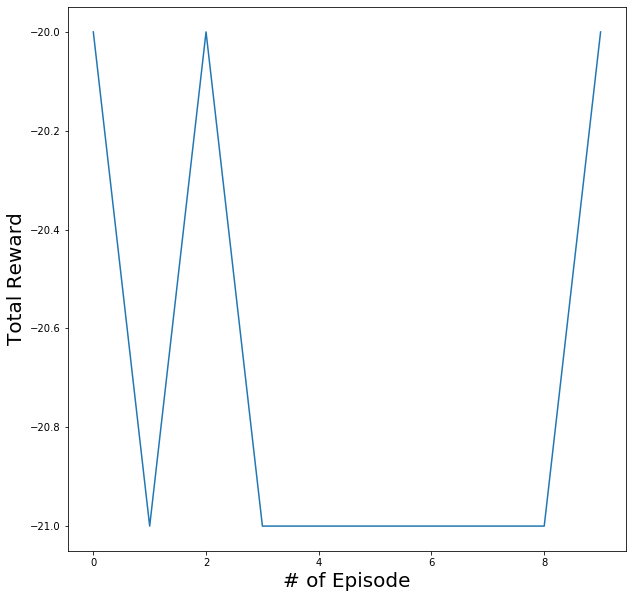

In [15]:
plt.figure(figsize = (10,10))
plt.plot(train_hist)
plt.plot(np.arange(0,EPISODE_MAX,10),
         np.array(train_hist).reshape(-1, 10).mean(axis = 1))
plt.xlabel('# of Episode', fontsize = 20)
plt.ylabel('Total Reward', fontsize = 20)

# Rendering policy

In [16]:
_ = simulate(env, 100, predict, True)


#  Saving Network parameters

In [ ]:
torch.save(Q.state_dict(), 'pong_Q')
torch.save(target_Q.state_dict(), 'pong_Q_target')

# Saving animation

In [9]:
env = gym.make('PongDeterministic-v4')

Q = DQN(env.action_space.n).to(device)
target_Q = DQN(env.action_space.n).to(device)
####### load model ##########

Q.load_state_dict(torch.load('pong_Q'))
target_Q.load_state_dict(torch.load('pong_Q_target'))

reward_tot, reward, t, done, frames = simulate(env, 500, predict, True)

In [12]:
from matplotlib import animation
def save_frames_as_gif(frames, path='./', filename='pong_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 200.0, frames[0].shape[0] / 200.0), dpi=144)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=0)
    anim.save(path + filename, writer='imagemagick', fps=12)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


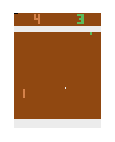

In [13]:
save_frames_as_gif(frames[::4])